<a href="https://colab.research.google.com/github/Pocho01/ProyectoCapstone/blob/main/ProyectoCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modelos de aprendizaje supervisado para el número de matrículas estudiantiles en Ecuador**


El presente notebook tiene como finalidad desarrollar e implementar diversos modelos de aprendizaje supervisado para estimar con alta precisión el número total de estudiantes matriculados en Ecuador, a partir de datos históricos. Para ello, se llevará a cabo un proceso integral que incluye la limpieza y preprocesamiento de datos, el análisis exploratorio (EDA), la selección de características relevantes, y la construcción, entrenamiento y evaluación comparativa de modelos de regresión. El objetivo final es identificar el modelo que proporcione el mejor desempeño predictivo, basado en métricas como RMSE y error relativo, con miras a su posible implementación en escenarios de planificación educativa y toma de decisiones a nivel nacional.

In [1]:
#Importamos todas las librerías necesarias para ejecutar el código
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import ipywidgets as widgets
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Cargar archivo (ajusta el nombre si trabajas localmente)
from google.colab import drive, files
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/registro-administrativo-historico_2009-2024-inicio.csv', sep=';', thousands='.', low_memory=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Mostrar las primeras filas del DataFrame para una vista previa de los datos.
df.head()

,Anio_lectivo,Zona,Provincia,Cod_Provincia,Canton,Cod_Canton,Parroquia,Cod_Parroquia,Nombre_Institucion,AMIE,...,Total_Docentes,Estudiantes_Femenino,Estudiantes_Masculino,Total_Estudiantes,Ecuatoriana,Colombiana,Venezolana,Peruana,Otros_Paises_de_America,Otros_Continentes
0,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,EL SAGRARIO,10104.0,UNIDAD EDUCATIVA PARTICULAR ROSA DE JESUS CORDERO,01B00002,...,96.0,1473.0,0.0,1473.0,1455,0,0,0,18,0
1,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,MONAY,10109.0,CEBCI,01B00010,...,25.0,148.0,179.0,327.0,311,3,0,0,9,4
2,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,CENTRO EDUCATIVO ROUSSEAU,01B00019,...,10.0,17.0,23.0,40.0,39,0,0,0,1,0
3,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,BAÑOS,10151.0,COLEGIO INTERCULTURAL BILINGUE DE NARANCAY,01B00020,...,17.0,132.0,132.0,264.0,264,0,0,0,0,0
4,2009-2010 Inicio,Zona 6,AZUAY,1.0,CUENCA,101.0,CHAUCHA,10153.0,SEIS DE JUNIO,01B00021,...,1.0,18.0,6.0,24.0,24,0,0,0,0,0


In [4]:
#Mostrar información general del DataFrame: número de filas, columnas, tipos de datos y valores no nulos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442716 entries, 0 to 442715
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anio_lectivo             322602 non-null  object 
 1   Zona                     322602 non-null  object 
 2   Provincia                322602 non-null  object 
 3   Cod_Provincia            322602 non-null  float64
 4   Canton                   322602 non-null  object 
 5   Cod_Canton               322602 non-null  float64
 6   Parroquia                322602 non-null  object 
 7   Cod_Parroquia            322602 non-null  float64
 8   Nombre_Institucion       322602 non-null  object 
 9   AMIE                     322602 non-null  object 
 10  Tipo_Educacion           322602 non-null  object 
 11  Sostenimiento            322602 non-null  object 
 12  Area                     322602 non-null  object 
 13  Regimen_Escolar          322602 non-null  object 
 14  Juri

In [5]:
# Crear una copia de trabajo del DataFrame original para realizar las modificaciones de limpieza y preprocesamiento.
df_clean = df.copy()

In [6]:
# Convertir 'Anio_lectivo' a solo el año de inicio
df_clean = df_clean[df_clean['Anio_lectivo'].notnull()].copy()
df_clean['Anio_Inicio'] = df_clean['Anio_lectivo'].str.extract(r'(\d{4})').astype(int)
# Eliminar la columna original 'Anio_lectivo'
df_clean = df_clean.drop('Anio_lectivo', axis=1)

In [7]:
# Seleccionar columnas tipo float
float_cols = df_clean.select_dtypes(include=['float']).columns

# Convertir columnas flotantes a enteros (si es posible sin perder información)
for col in float_cols:
    # Verificar si la columna contiene solo valores enteros representados como float
    if (df_clean[col] == df_clean[col].astype(int)).all():
        df_clean[col] = df_clean[col].astype(int)
    else:
        print(f"La columna '{col}' contiene valores no enteros y no se puede convertir a int sin pérdida.")

In [8]:
#Estandarizar columnas de texto
text_columns = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

for col in text_columns:
    df_clean[col] = df_clean[col].str.strip().str.lower().str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [9]:
# Lista de columnas categóricas a codificar
vars_to_encode = ['Tipo_Educacion', 'Sostenimiento', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Codificación one-hot (dummies), eliminando la primera categoría para evitar multicolinealidad
df_clean = pd.get_dummies(df_clean, columns=vars_to_encode, drop_first=True)

In [10]:
# Lista de columnas de interés, incluyendo las originales y las codificadas
# Las columnas codificadas tendrán prefijos basados en los nombres originales
# de las columnas categóricas
columns_of_interest = [
    'Cod_Provincia',
    'Total_Docentes',
    'Total_Estudiantes',
    'Anio_Inicio'
]

# Agregar dinámicamente las columnas codificadas a la lista de interés
# Iteramos sobre las columnas de df_clean y agregamos aquellas que son resultado de get_dummies
for col in df_clean.columns:
    # Comprobamos si la columna comienza con alguno de los prefijos de las variables codificadas
    if any(col.startswith(prefix + '_') for prefix in vars_to_encode):
        columns_of_interest.append(col)

# Crear un nuevo DataFrame con las columnas seleccionadas
df_selected = df_clean[columns_of_interest].copy()

# Mostrar información del nuevo DataFrame para verificar los tipos de datos y columnas
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Index: 322602 entries, 0 to 322601
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   Cod_Provincia                        322602 non-null  int64
 1   Total_Docentes                       322602 non-null  int64
 2   Total_Estudiantes                    322602 non-null  int64
 3   Anio_Inicio                          322602 non-null  int64
 4   Tipo_Educacion_ordinario             322602 non-null  bool 
 5   Tipo_Educacion_popular permanente    322602 non-null  bool 
 6   Sostenimiento_fiscomisional          322602 non-null  bool 
 7   Sostenimiento_municipal              322602 non-null  bool 
 8   Sostenimiento_particular             322602 non-null  bool 
 9   Area_urbana                          322602 non-null  bool 
 10  Regimen_Escolar_sierra               322602 non-null  bool 
 11  Jurisdiccion_intercultural bilingue  322602 

In [11]:
# Eliminamos la provincia 90 de nuestro dataframe por falta de registros en algunos años
df_selected = df_selected[df_selected['Cod_Provincia'] != 90].copy()

In [12]:
# Crear copia de df_selected
df_new = df_selected.copy()

In [13]:
#Convertir el año en un índice de tipo datetime
df_selected['Anio'] = pd.to_datetime(df_selected['Anio_Inicio'], format='%Y')
df_selected.set_index('Anio', inplace=True)

# Eliminar la columna Anio_Inicio
df_selected.drop(columns='Anio_Inicio', inplace=True)

In [14]:
# Mostrar las primeras filas del DataFrame con el índice de tiempo.
df_selected.head()

,Cod_Provincia,Total_Docentes,Total_Estudiantes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue
Anio,,,,,,,,,,,
2009-01-01,1,96,1473,True,False,False,False,True,True,True,False
2009-01-01,1,25,327,True,False,False,False,True,True,True,True
2009-01-01,1,10,40,True,False,False,False,True,False,True,True
2009-01-01,1,17,264,True,False,False,False,False,False,True,True
2009-01-01,1,1,24,True,False,False,False,False,False,False,True


In [15]:
#Mostrar estadísticas descriptivas para las columnas 'Total_Docentes' y 'Total_Estudiantes'.
df_selected[["Total_Docentes", "Total_Estudiantes"]].describe()

,Total_Docentes,Total_Estudiantes
count,321878.000000,321878.000000
mean,10.938582,218.183100
std,18.071431,410.068347
min,0.000000,1.000000
25%,1.000000,21.000000
50%,4.000000,58.000000
75%,13.000000,222.000000
max,374.000000,9463.000000


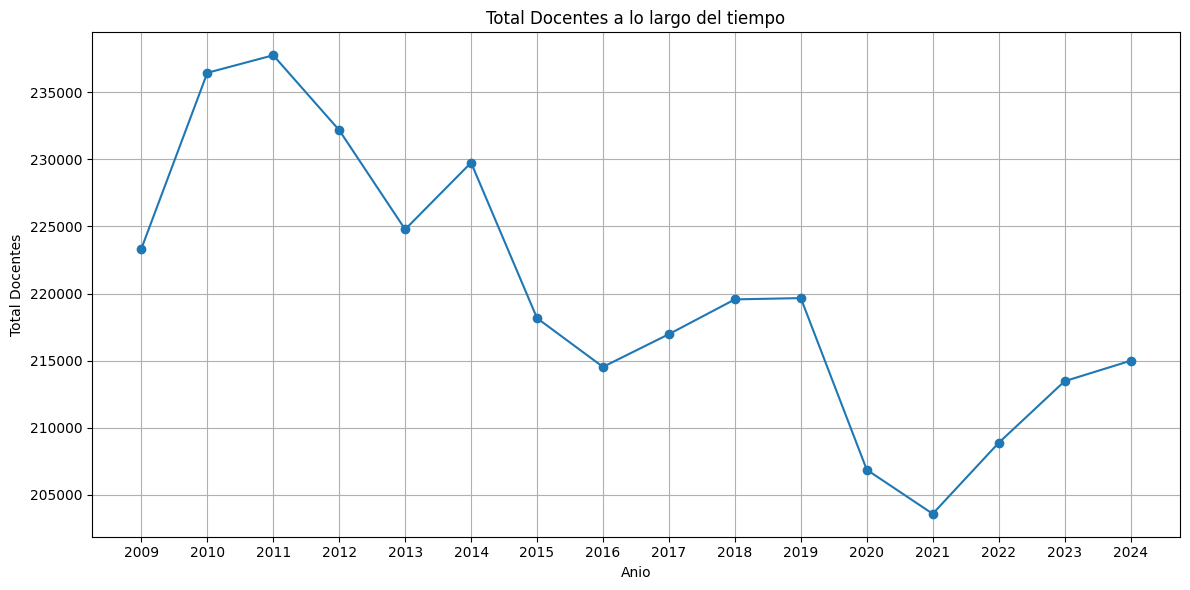

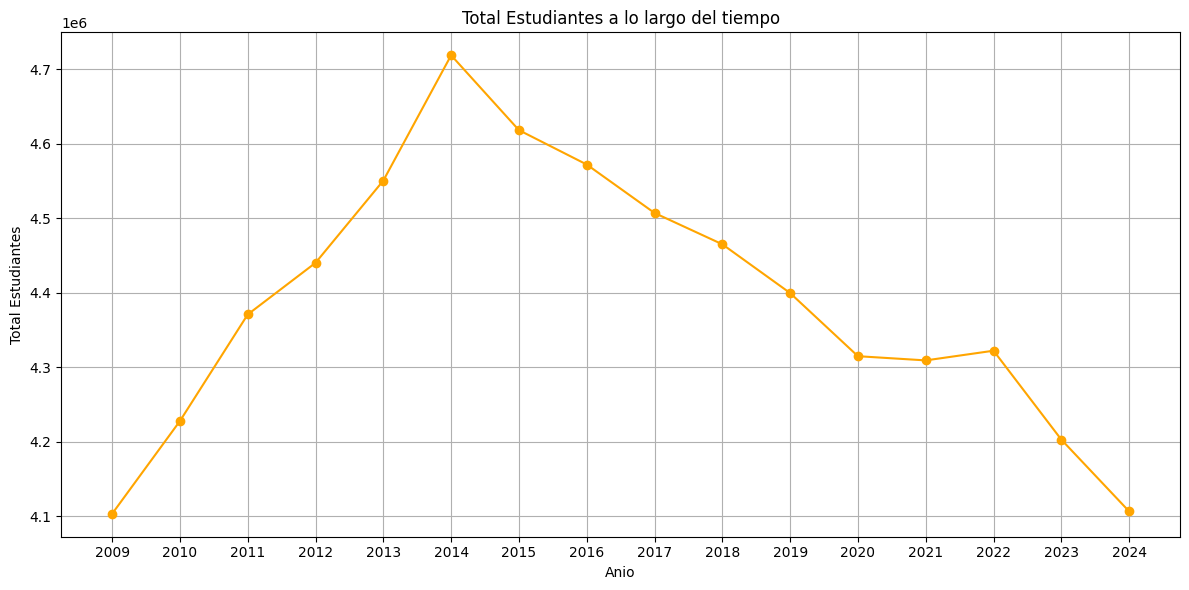

In [16]:
# Agrupar por año y sumar 'Total_Docentes' y 'Total_Estudiantes'
df_yearly_totals = df_selected.groupby('Anio')[['Total_Docentes', 'Total_Estudiantes']].sum()

# Graficar Total_Docentes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Docentes'], marker='o', linestyle='-')
plt.title('Total Docentes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Docentes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

# Graficar Total_Estudiantes a lo largo del tiempo (solo año)
plt.figure(figsize=(12, 6))
plt.plot(df_yearly_totals.index.year, df_yearly_totals['Total_Estudiantes'], marker='o', linestyle='-', color='orange')
plt.title('Total Estudiantes a lo largo del tiempo')
plt.xlabel('Anio')
plt.ylabel('Total Estudiantes')
plt.grid(True)
plt.xticks(df_yearly_totals.index.year) # Asegura que solo se muestren los años en el eje x
plt.tight_layout()
plt.show()

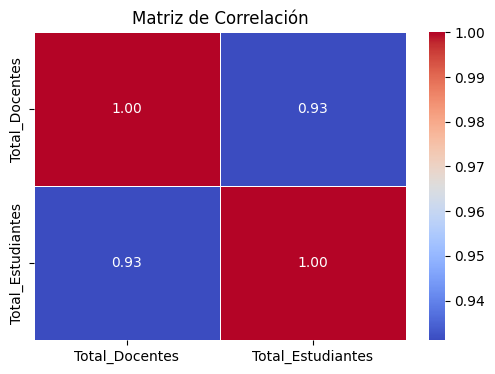

In [17]:
# Calcular la correlación entre 'Total_Docentes' y 'Total_Estudiantes'
corr = df_selected[["Total_Docentes", "Total_Estudiantes"]].corr()

# Dibujar un heatmap de la matriz de correlación.
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

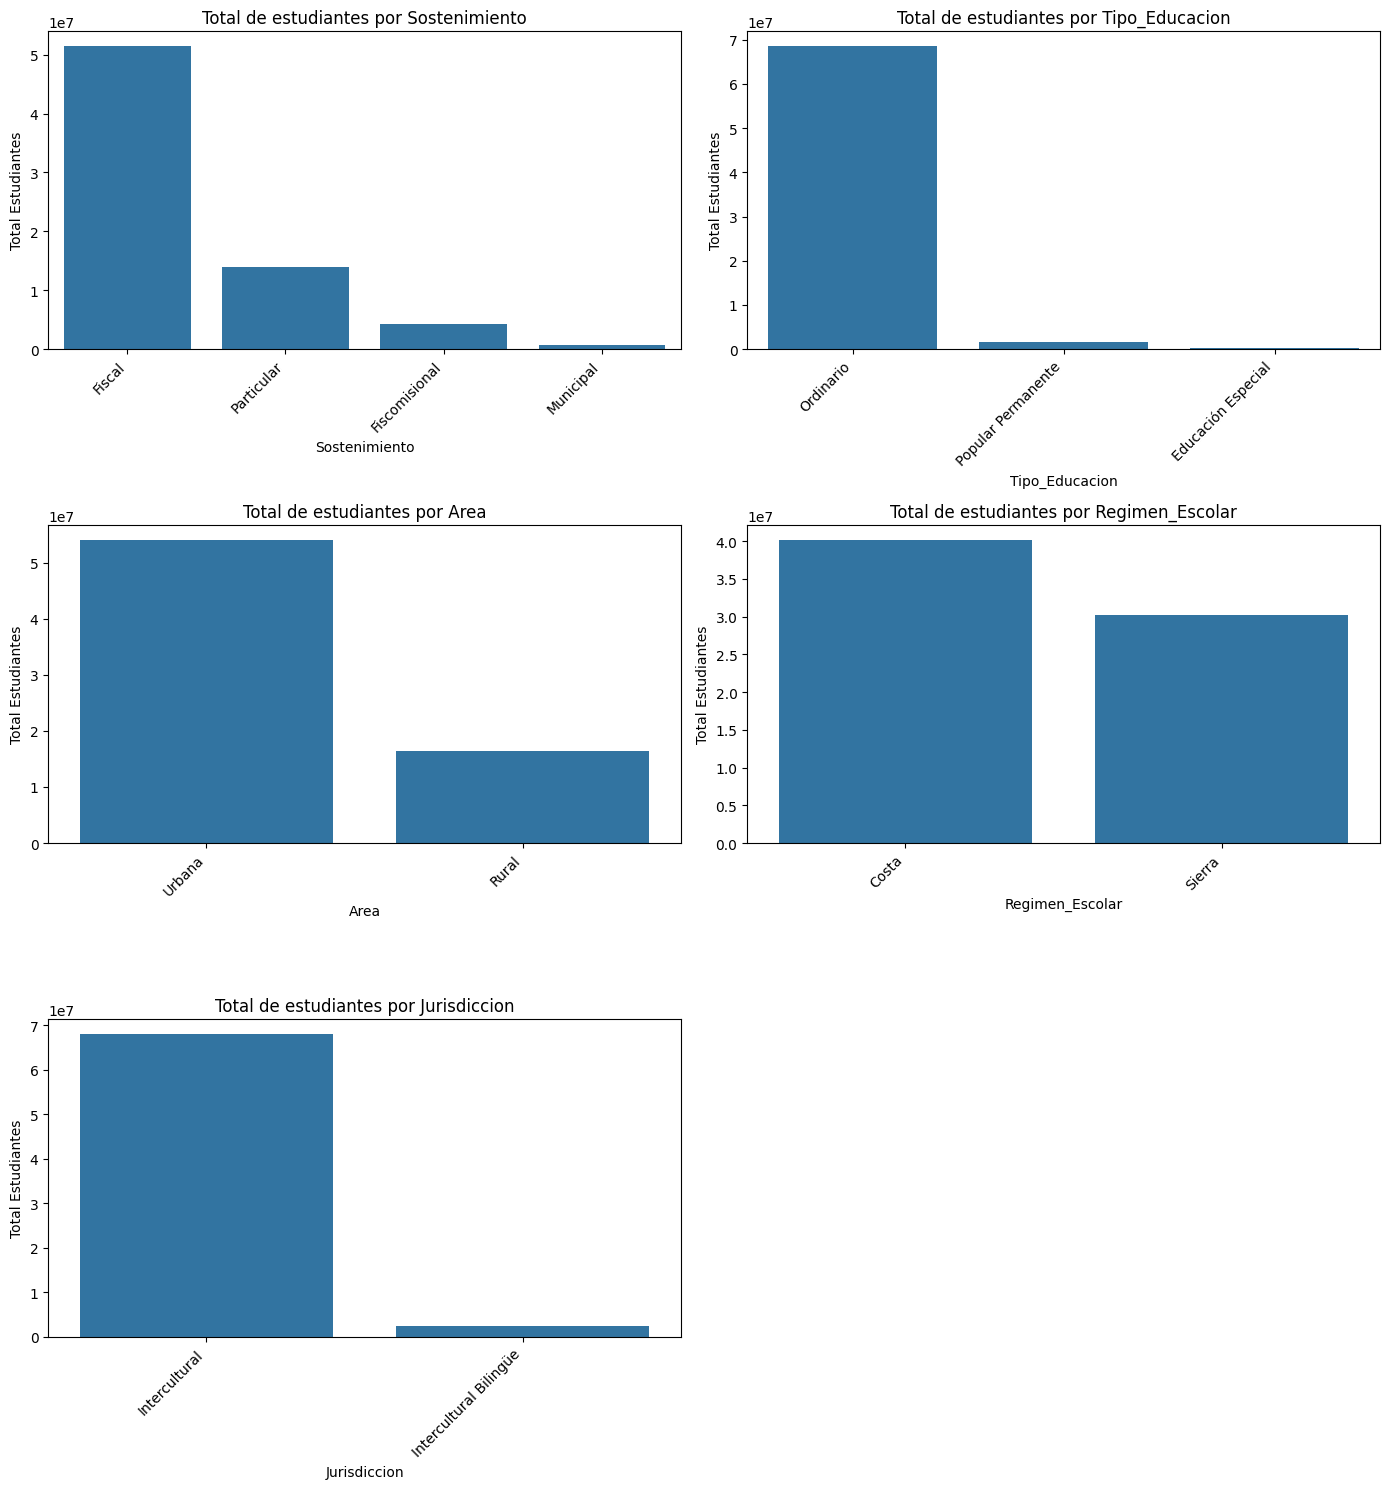

In [18]:
# Variables categóricas para visualización.
categorical_vars = ['Sostenimiento', 'Tipo_Educacion', 'Area', 'Regimen_Escolar', 'Jurisdiccion']

# Configurar subplots para graficar cada variable categórica por separado.
n = len(categorical_vars)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Graficar el total de estudiantes por cada variable categórica.
for i, var in enumerate(categorical_vars):
    df_viz = df.groupby(var)['Total_Estudiantes'].sum().reset_index().sort_values(by='Total_Estudiantes', ascending=False)

    sns.barplot(data=df_viz, x=var, y='Total_Estudiantes', ax=axes[i])
    axes[i].set_title(f'Total de estudiantes por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Total Estudiantes')

    # Rotar etiquetas de eje x correctamente
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

# Eliminar subplots vacíos si hay más ejes que variables categóricas.
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
# Lista de columnas que se van a sumar (totales por provincia y año)
cols_sum = ['Total_Estudiantes', 'Total_Docentes']
# Lista de columnas a las que se les calculará el promedio (columnas dummy creadas por get_dummies).
# Se excluyen las columnas de suma y las columnas de identificación/tiempo.
cols_mean = [col for col in df_new.columns if col not in ['Cod_Provincia', 'Anio_Inicio'] + cols_sum]


# Agrupamos por Cod_Provincia y Anio_Inicio y sumamos las columnas especificadas
df_agg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_sum].sum().reset_index()
# Agrupamos por Cod_Provincia y Anio_Inicio y calculamos el promedio de las columnas dummy.
df_dummy_avg = df_new.groupby(['Cod_Provincia', 'Anio_Inicio'])[cols_mean].mean().reset_index()

# Unimos los resultados de las agrupaciones por provincia y año.
df_final = pd.merge(df_agg, df_dummy_avg, on=['Cod_Provincia', 'Anio_Inicio'])

In [20]:
# Crear variables de retraso (lags) para 'Total_Estudiantes'.
# Se crean lags de 1 a 3 años para capturar la dependencia temporal.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final.groupby('Cod_Provincia')['Total_Estudiantes'].shift(i)

# Eliminar las filas que contienen valores nulos debido a los lags (las primeras filas de cada provincia).
df_final = df_final.dropna().reset_index(drop=True)

# Convertir las columnas de lag a tipo entero.
for i in range(1, 4):
    df_final[f'Total_Estudiantes_lag{i}'] = df_final[f'Total_Estudiantes_lag{i}'].astype(int)


In [21]:
# Mostrar las primeras filas del DataFrame final con las columnas de lag.
df_final.head()

,Cod_Provincia,Anio_Inicio,Total_Estudiantes,Total_Docentes,Tipo_Educacion_ordinario,Tipo_Educacion_popular permanente,Sostenimiento_fiscomisional,Sostenimiento_municipal,Sostenimiento_particular,Area_urbana,Regimen_Escolar_sierra,Jurisdiccion_intercultural bilingue,Total_Estudiantes_lag1,Total_Estudiantes_lag2,Total_Estudiantes_lag3
0,1,2012,213675,11568,0.923077,0.065295,0.062612,0.010733,0.173524,0.503578,0.759392,0.035778,211092,203494,199677
1,1,2013,219571,11791,0.955366,0.032289,0.029440,0.009497,0.189934,0.503324,0.776828,0.037037,213675,211092,203494
2,1,2014,222499,11703,0.957086,0.030938,0.036926,0.009980,0.181637,0.498004,0.773453,0.035928,219571,213675,211092
3,1,2015,221404,11398,0.955319,0.031915,0.040426,0.011702,0.192553,0.511702,0.768085,0.035106,222499,219571,213675
4,1,2016,218808,11004,0.959954,0.026316,0.044622,0.011442,0.187643,0.525172,0.763158,0.034325,221404,222499,219571


In [22]:
# Obtener la lista de códigos de provincia únicos del DataFrame final
provinces = df_final['Cod_Provincia'].unique()

# Diccionario para almacenar las divisiones (splits) para cada provincia
province_data_splits = {}

# Iterar a través de cada provincia única
for cod_provincia in provinces:
    # Filtrar el DataFrame final para obtener solo los datos de la provincia actual
    df_prov = df_final[df_final['Cod_Provincia'] == cod_provincia].copy() # Se crea una copia para evitar advertencias

    # Separar las características (X) y la variable objetivo (y) para los datos de esta provincia
    X_prov = df_prov.drop(columns=["Total_Estudiantes"])
    y_prov = df_prov["Total_Estudiantes"]

    # Dividir los datos de la provincia en conjuntos de entrenamiento y prueba basándose en el año
    # Los datos hasta 2021 son para entrenamiento
    X_train_prov = X_prov[df_prov["Anio_Inicio"] <= 2021]
    y_train_prov = y_prov[df_prov["Anio_Inicio"] <= 2021]

    # Los datos después de 2021 son para pruebas
    X_test_prov = X_prov[df_prov["Anio_Inicio"] > 2021]
    y_test_prov = y_prov[df_prov["Anio_Inicio"] > 2021]

    # Almacenar las divisiones (X_train, y_train, X_test, y_test) en el diccionario
    # La clave del diccionario es el código de la provincia
    province_data_splits[cod_provincia] = {
        'X_train': X_train_prov,
        'y_train': y_train_prov,
        'X_test': X_test_prov,
        'y_test': y_test_prov
    }

print("\nDivisiones de datos creadas para todas las provincias y almacenadas en el diccionario 'province_data_splits'.")


Divisiones de datos creadas para todas las provincias y almacenadas en el diccionario 'province_data_splits'.


In [23]:
# Diccionario para almacenar los modelos de XGBRegressor por provincia
xgbr_models_por_provincia = {}
# Diccionario para almacenar los errores relativos por provincia
xgbr_error_relativo_por_provincia = {}
# Diccionario para almacenar los resultados de predicción de XGBRegressor por provincia
xgbr_predictions_por_provincia = {}
# Diccionario para almacenar los resultados de evaluación (RMSE, R2) de XGBRegressor por provincia
# Vamos a cambiar esto para almacenar el Error Relativo y R2
xgbr_evaluacion_por_provincia = {}


# Obtener la lista única de códigos de provincia en el conjunto de prueba
all_X_test = pd.concat([split['X_test'] for split in province_data_splits.values()])
provincias_test = all_X_test['Cod_Provincia'].unique()

# Iterar sobre cada provincia
for cod_provincia in provincias_test:
    X_train_prov = province_data_splits[cod_provincia]['X_train']
    y_train_prov = province_data_splits[cod_provincia]['y_train']
    X_test_prov = province_data_splits[cod_provincia]['X_test']
    y_test_prov = province_data_splits[cod_provincia]['y_test']

    if not X_train_prov.empty and not X_test_prov.empty:
        # Entrenar modelo
        xgbr_model_prov = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
        xgbr_model_prov.fit(X_train_prov, y_train_prov)

        # Almacenar el modelo entrenado
        xgbr_models_por_provincia[cod_provincia] = xgbr_model_prov

        # Predicción
        y_pred_xgbr_prov = xgbr_model_prov.predict(X_test_prov)

        # Almacenar las predicciones
        xgbr_predictions_por_provincia[cod_provincia] = y_pred_xgbr_prov

        # RMSE y error relativo
        mse_xgbr_prov = mean_squared_error(y_test_prov, y_pred_xgbr_prov)
        rmse_xgbr_prov = np.sqrt(mse_xgbr_prov)
        r2_xgbr_prov = r2_score(y_test_prov, y_pred_xgbr_prov)

        # Calcular el Error Relativo
        media_real_xgbr = np.mean(y_test_prov)

        # Evitar división por cero
        if media_real_xgbr != 0:
            error_relativo_xgbr = (rmse_xgbr_prov / media_real_xgbr) * 100
        else:
            error_relativo_xgbr = float('inf') # Usar infinito si la media es cero

        # Almacenar todas las métricas de evaluación en el diccionario xgbr_evaluacion_por_provincia
        xgbr_evaluacion_por_provincia[cod_provincia] = {
            'RMSE': rmse_xgbr_prov,
            'R2': r2_xgbr_prov,
            'Error Relativo (%)': error_relativo_xgbr
        }

    else:
        print(f"No hay suficientes datos para la provincia {cod_provincia} para entrenar XGBoost. Saltando...")

# Ordenar de menor a mayor error relativo para el resumen final
# Usamos el Error Relativo (%) almacenado en xgbr_evaluacion_por_provincia para ordenar
resultados_xgbr_ordenados = sorted(xgbr_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%)'])

print("\nResumen Final de Evaluación de XGBoost por Provincia (ordenado por Error Relativo):")

# Iterar sobre los resultados ordenados para imprimir el resumen
for cod_provincia, metrics in resultados_xgbr_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE']:.2f}, R2 = {metrics['R2']:.2f}, Error Relativo = {metrics['Error Relativo (%)']:.2f}%")

# Identificar la provincia con el menor error relativo
if resultados_xgbr_ordenados:
    mejor_provincia = resultados_xgbr_ordenados[0]
    print(f"\nLa provincia con el menor error relativo es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%)']:.2f}%")
else:
    print("\nNo se pudieron calcular métricas de evaluación para ninguna provincia.")


Resumen Final de Evaluación de XGBoost por Provincia (ordenado por Error Relativo):
Provincia Código 19: RMSE = 368.17, R2 = -9.34, Error Relativo = 1.11%
Provincia Código 16: RMSE = 438.05, R2 = -0.85, Error Relativo = 1.24%
Provincia Código 13: RMSE = 5134.70, R2 = -0.03, Error Relativo = 1.28%
Provincia Código 14: RMSE = 969.27, R2 = -0.49, Error Relativo = 1.48%
Provincia Código 23: RMSE = 2849.60, R2 = -0.71, Error Relativo = 2.10%
Provincia Código 9: RMSE = 25581.60, R2 = -0.27, Error Relativo = 2.40%
Provincia Código 24: RMSE = 2629.64, R2 = -1.65, Error Relativo = 2.49%
Provincia Código 12: RMSE = 6027.89, R2 = -0.32, Error Relativo = 2.66%
Provincia Código 7: RMSE = 5799.03, R2 = -2.02, Error Relativo = 3.39%
Provincia Código 10: RMSE = 4331.53, R2 = -2.41, Error Relativo = 3.66%
Provincia Código 18: RMSE = 4951.94, R2 = -2.08, Error Relativo = 3.76%
Provincia Código 22: RMSE = 2251.30, R2 = -7.86, Error Relativo = 3.85%
Provincia Código 1: RMSE = 7830.19, R2 = -2.42, Error R

In [24]:
# Diccionario para almacenar los modelos de Random Forest por provincia
rf_models_por_provincia = {}
# Diccionario para almacenar los resultados de predicción de Random Forest por provincia
rf_predictions_por_provincia = {}
# Diccionario para almacenar los resultados de evaluación (RMSE, R2) de Random Forest por provincia
# Vamos a cambiar esto para almacenar el Error Relativo y R2
rf_evaluacion_por_provincia = {}
# Diccionario para almacenar el error relativo por provincia para el Random Forest
rf_error_relativo_por_provincia = {}


# Iterar sobre cada provincia para la que tenemos datos divididos
for cod_provincia, splits in province_data_splits.items():
    X_train_prov = splits['X_train']
    y_train_prov = splits['y_train']
    X_test_prov = splits['X_test']
    y_test_prov = splits['y_test']

    # Asegurarse de que haya datos tanto en entrenamiento como en prueba para la provincia
    if not X_train_prov.empty and not X_test_prov.empty:
        #print(f"Entrenando Random Forest para la Provincia Codigo: {cod_provincia}...")

        # Inicializar y entrenar el modelo Random Forest para la provincia actual
        # Puedes ajustar los hiperparámetros según sea necesario
        rf_model_prov = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
        rf_model_prov.fit(X_train_prov, y_train_prov)

        # Almacenar el modelo entrenado
        rf_models_por_provincia[cod_provincia] = rf_model_prov

        # Realizar predicciones para la provincia actual
        y_pred_rf_prov = rf_model_prov.predict(X_test_prov)

        # Almacenar las predicciones
        rf_predictions_por_provincia[cod_provincia] = y_pred_rf_prov

        # Evaluar el modelo para la provincia actual
        mse_rf_prov = mean_squared_error(y_test_prov, y_pred_rf_prov)
        rmse_rf_prov = np.sqrt(mse_rf_prov)
        r2_rf_prov = r2_score(y_test_prov, y_pred_rf_prov)

        # Calcular el Error Relativo
        media_real_rf = np.mean(y_test_prov)
        # Evitar división por cero
        if media_real_rf != 0:
            error_relativo_rf = (rmse_rf_prov / media_real_rf) * 100
        else:
            error_relativo_rf = float('inf') # Usar infinito si la media es cero

        # Almacenar todas las métricas de evaluación en el diccionario rf_evaluacion_por_provincia
        rf_evaluacion_por_provincia[cod_provincia] = {
            'RMSE': rmse_rf_prov,
            #'R2': r2_rf_prov,
            'Error Relativo (%)': error_relativo_rf
        }

    else:
        print(f"No hay suficientes datos para la provincia {cod_provincia} para entrenar Random Forest. Saltando...")

# Ordenar de menor a mayor error relativo para el resumen final
# Usamos el Error Relativo (%) almacenado en rf_evaluacion_por_provincia para ordenar
resultados_rf_ordenados = sorted(rf_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%)'])

print("\nResumen Final de Evaluación de RandomForest por Provincia (ordenado por Error Relativo):")

# Iterar sobre los resultados ordenados para imprimir el resumen
for cod_provincia, metrics in resultados_rf_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE']:.2f}, Error Relativo = {metrics['Error Relativo (%)']:.2f}%")

# Identificar la provincia con el menor error relativo
if resultados_rf_ordenados:
    mejor_provincia = resultados_rf_ordenados[0]
    print(f"\nLa provincia con el menor error relativo es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%)']:.2f}%")
else:
    print("\nNo se pudieron calcular métricas de evaluación para ninguna provincia.")


Resumen Final de Evaluación de RandomForest por Provincia (ordenado por Error Relativo):
Provincia Código 14: RMSE = 825.66, Error Relativo = 1.26%
Provincia Código 13: RMSE = 5675.37, Error Relativo = 1.42%
Provincia Código 16: RMSE = 660.38, Error Relativo = 1.86%
Provincia Código 20: RMSE = 137.54, Error Relativo = 1.89%
Provincia Código 19: RMSE = 661.80, Error Relativo = 2.00%
Provincia Código 24: RMSE = 2469.95, Error Relativo = 2.34%
Provincia Código 9: RMSE = 25861.52, Error Relativo = 2.43%
Provincia Código 22: RMSE = 2039.83, Error Relativo = 3.49%
Provincia Código 12: RMSE = 8355.06, Error Relativo = 3.68%
Provincia Código 7: RMSE = 7001.37, Error Relativo = 4.09%
Provincia Código 23: RMSE = 5563.03, Error Relativo = 4.09%
Provincia Código 21: RMSE = 2709.07, Error Relativo = 4.38%
Provincia Código 18: RMSE = 6945.24, Error Relativo = 5.28%
Provincia Código 10: RMSE = 6643.91, Error Relativo = 5.61%
Provincia Código 15: RMSE = 2464.26, Error Relativo = 6.00%
Provincia Códig

In [25]:
# Diccionario para almacenar los modelos de Árboles de Decisión por provincia
dt_models_por_provincia = {}
# Diccionario para almacenar los resultados de predicción de Árboles de Decisión por provincia
dt_predictions_por_provincia = {}
# Diccionario para almacenar los resultados de evaluación (Error Relativo %, R2) de Árboles de Decisión por provincia
# Cambiamos esto para almacenar Error Relativo y R2
dt_evaluacion_por_provincia = {}
# Diccionario para almacenar el error relativo por provincia para el Árbol de Decisión
dt_error_relativo_por_provincia = {}


# Iterar sobre cada provincia para la que tenemos datos divididos
for cod_provincia, splits in province_data_splits.items():
    X_train_prov = splits['X_train']
    y_train_prov = splits['y_train']
    X_test_prov = splits['X_test']
    y_test_prov = splits['y_test']

    # Asegurarse de que haya datos tanto en entrenamiento como en prueba para la provincia
    if not X_train_prov.empty and not X_test_prov.empty:
        #print(f"Entrenando Árbol de Decisión para la Provincia Codigo: {cod_provincia}...")

        # Inicializar y entrenar el modelo de Árbol de Decisión para la provincia actual
        # Puedes ajustar los hiperparámetros según sea necesario (ej: max_depth)
        dt_model_prov = DecisionTreeRegressor(max_depth=10, random_state=42)
        dt_model_prov.fit(X_train_prov, y_train_prov)

        # Almacenar el modelo entrenado
        dt_models_por_provincia[cod_provincia] = dt_model_prov

        # Realizar predicciones para la provincia actual
        y_pred_dt_prov = dt_model_prov.predict(X_test_prov)

        # Almacenar las predicciones
        dt_predictions_por_provincia[cod_provincia] = y_pred_dt_prov

        # Evaluar el modelo para la provincia actual
        mse_dt_prov = mean_squared_error(y_test_prov, y_pred_dt_prov)
        rmse_dt_prov = np.sqrt(mse_dt_prov)
        r2_dt_prov = r2_score(y_test_prov, y_pred_dt_prov)

        # Calcular el Error Relativo
        media_real_dt = np.mean(y_test_prov)
        if media_real_dt != 0:
            error_relativo_dt = (rmse_dt_prov / media_real_dt) * 100
        else:
            error_relativo_dt = float('inf') # Usar infinito si la media es cero

        # Almacenar todas las métricas de evaluación en el diccionario dt_evaluacion_por_provincia
        dt_evaluacion_por_provincia[cod_provincia] = {
            'RMSE': rmse_dt_prov,
            #'R2': r2_dt_prov,
            'Error Relativo (%)': error_relativo_dt
        }

    else:
        print(f"No hay suficientes datos para la provincia {cod_provincia} para entrenar Decision Tree. Saltando...")

# Ordenar de menor a mayor error relativo para el resumen final
# Usamos el Error Relativo (%) almacenado en dt_evaluacion_por_provincia para ordenar
resultados_dt_ordenados = sorted(dt_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%)'])

print("\nResumen Final de Evaluación de DecisionTree por Provincia (ordenado por Error Relativo):")

# Iterar sobre los resultados ordenados para imprimir el resumen
for cod_provincia, metrics in resultados_dt_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE']:.2f}, Error Relativo = {metrics['Error Relativo (%)']:.2f}%")

# Identificar la provincia con el menor error relativo
if resultados_dt_ordenados:
    mejor_provincia = resultados_dt_ordenados[0]
    print(f"\nLa provincia con el menor error relativo es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%)']:.2f}%")
else:
    print("\nNo se pudieron calcular métricas de evaluación para ninguna provincia.")


Resumen Final de Evaluación de DecisionTree por Provincia (ordenado por Error Relativo):
Provincia Código 19: RMSE = 381.90, Error Relativo = 1.16%
Provincia Código 13: RMSE = 5189.07, Error Relativo = 1.30%
Provincia Código 14: RMSE = 997.56, Error Relativo = 1.52%
Provincia Código 20: RMSE = 127.86, Error Relativo = 1.76%
Provincia Código 9: RMSE = 22193.50, Error Relativo = 2.08%
Provincia Código 12: RMSE = 5496.59, Error Relativo = 2.42%
Provincia Código 24: RMSE = 3038.00, Error Relativo = 2.88%
Provincia Código 7: RMSE = 5873.54, Error Relativo = 3.43%
Provincia Código 16: RMSE = 1275.12, Error Relativo = 3.60%
Provincia Código 10: RMSE = 4331.42, Error Relativo = 3.66%
Provincia Código 18: RMSE = 4951.77, Error Relativo = 3.76%
Provincia Código 1: RMSE = 7829.74, Error Relativo = 4.01%
Provincia Código 22: RMSE = 2414.70, Error Relativo = 4.13%
Provincia Código 11: RMSE = 4759.99, Error Relativo = 4.15%
Provincia Código 21: RMSE = 3473.79, Error Relativo = 5.61%
Provincia Códig

In [26]:
# Diccionarios para almacenar resultados
scalers_por_provincia = {}
nn_models_por_provincia = {}
nn_predictions_por_provincia = {}
nn_evaluacion_por_provincia = {}

# Iterar sobre cada provincia
for cod_provincia, splits in province_data_splits.items():
    X_train_prov = splits['X_train'].copy()
    y_train_prov = splits['y_train'].copy()
    X_test_prov = splits['X_test'].copy()
    y_test_prov = splits['y_test'].copy()

    if not X_train_prov.empty and not X_test_prov.empty:
        # Escalamiento independiente para cada provincia
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train_prov)
        y_train_scaled = scaler_y.fit_transform(y_train_prov.values.reshape(-1, 1))

        X_test_scaled = scaler_X.transform(X_test_prov)
        y_test_scaled = scaler_y.transform(y_test_prov.values.reshape(-1, 1))

        scalers_por_provincia[cod_provincia] = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

        # Crear el modelo MLP
        model_nn_prov = Sequential()
        model_nn_prov.add(tf.keras.Input(shape=(X_train_scaled.shape[1],)))
        model_nn_prov.add(Dense(64, activation='relu'))
        model_nn_prov.add(Dense(32, activation='relu'))
        model_nn_prov.add(Dense(1))

        model_nn_prov.compile(optimizer='adam', loss='mse')

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model_nn_prov.fit(X_train_scaled, y_train_scaled,
                                    epochs=200,
                                    batch_size=32,
                                    validation_split=0.2,
                                    callbacks=[early_stopping],
                                    verbose=0)

        nn_models_por_provincia[cod_provincia] = model_nn_prov

        # Predicciones
        y_pred_nn_scaled_prov = model_nn_prov.predict(X_test_scaled)
        y_pred_nn_prov = scaler_y.inverse_transform(y_pred_nn_scaled_prov)

        nn_predictions_por_provincia[cod_provincia] = y_pred_nn_prov.flatten()

        # Evaluación
        mse_nn_prov = mean_squared_error(y_test_prov, y_pred_nn_prov)
        rmse_nn_prov = np.sqrt(mse_nn_prov)
        r2_nn_prov = r2_score(y_test_prov, y_pred_nn_prov)

        # Calcular el Error Relativo
        media_real_nn = np.mean(y_test_prov)
        if media_real_nn != 0:
            error_relativo_nn = (rmse_nn_prov / media_real_nn) * 100
        else:
            error_relativo_nn = float('inf')  # Usar infinito si la media es cero

        # Almacenar todas las métricas de evaluación en el diccionario nn_evaluacion_por_provincia
        nn_evaluacion_por_provincia[cod_provincia] = {
            'RMSE': rmse_nn_prov,
            # 'R2': r2_nn_prov,
            'Error Relativo (%)': error_relativo_nn
        }

    else:
        print(f"No hay suficientes datos para la provincia {cod_provincia} para entrenar MLP. Saltando...")

# Ordenar de menor a mayor error relativo para el resumen final
resultados_nn_ordenados = sorted(nn_evaluacion_por_provincia.items(), key=lambda x: x[1]['Error Relativo (%)'])

print("\nResumen Final de Evaluación de Red Neuronal (MLP) por Provincia (ordenado por Error Relativo):")

for cod_provincia, metrics in resultados_nn_ordenados:
    print(f"Provincia Código {cod_provincia}: RMSE = {metrics['RMSE']:.2f}, Error Relativo = {metrics['Error Relativo (%)']:.2f}%")

if resultados_nn_ordenados:
    mejor_provincia = resultados_nn_ordenados[0]
    print(f"\nLa provincia con el menor error relativo es la {mejor_provincia[0]} con un error de {mejor_provincia[1]['Error Relativo (%)']:.2f}%")
else:
    print("\nNo se pudieron calcular métricas de evaluación para ninguna provincia.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Resumen Final de Evaluación de Red Neuronal (MLP) por Provincia (ordenado por Error Relativo):
Provincia Código 14: RMSE = 1024.63, Error Relativo = 1.57%
Provincia Código 16: RMSE = 573.64, Error Relativo = 1.62%
Provincia Código 23: RMSE = 2306.66, Error Relativo = 1.70%


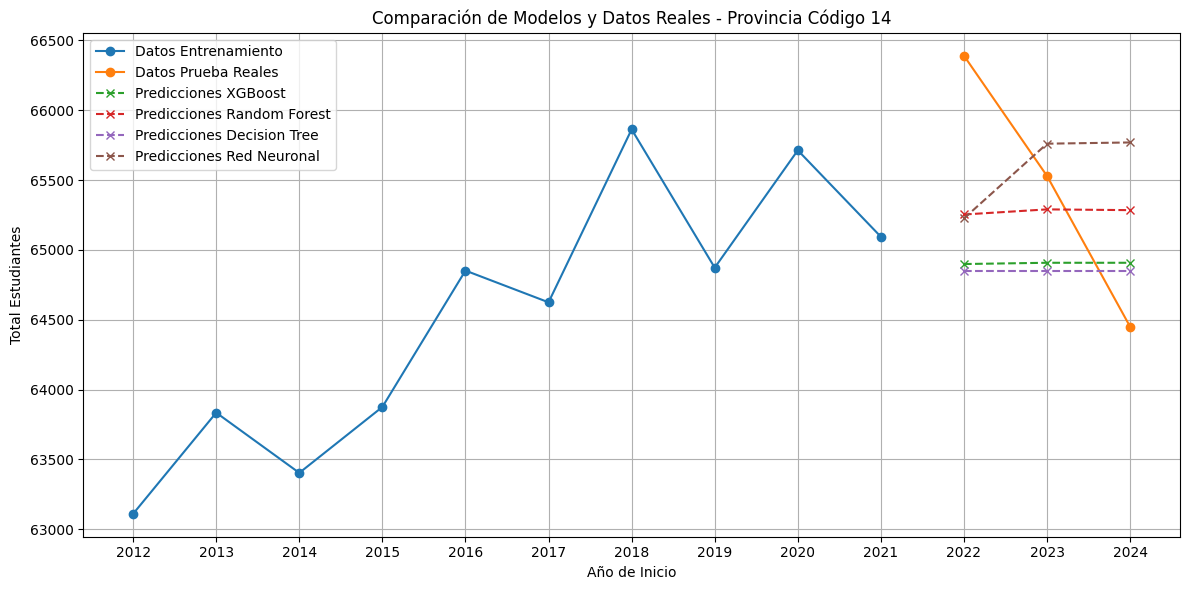

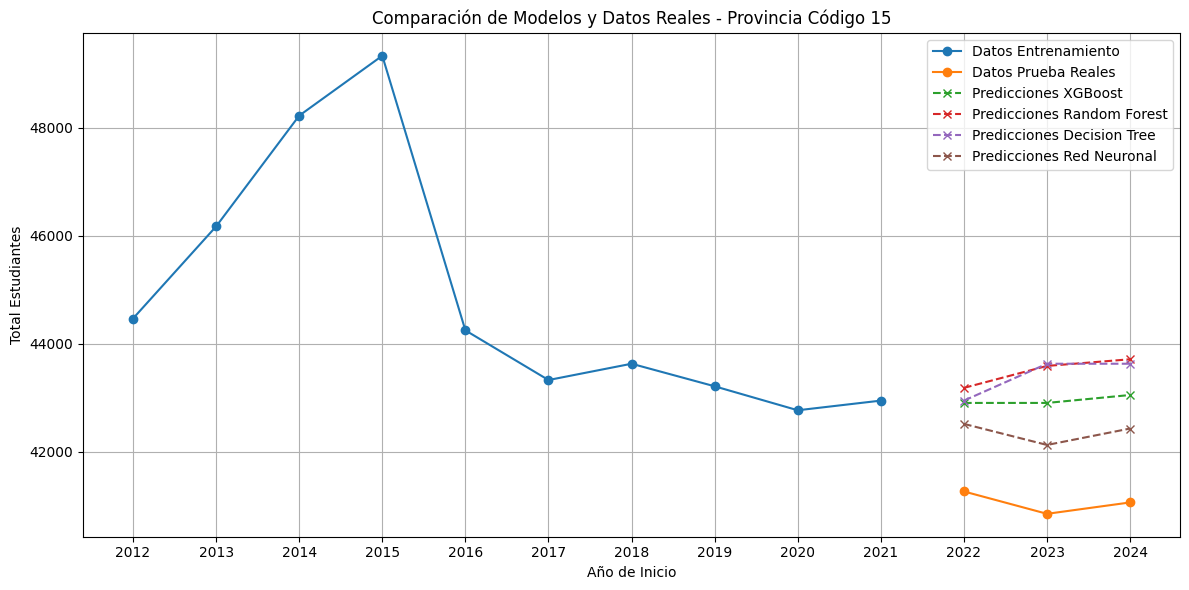

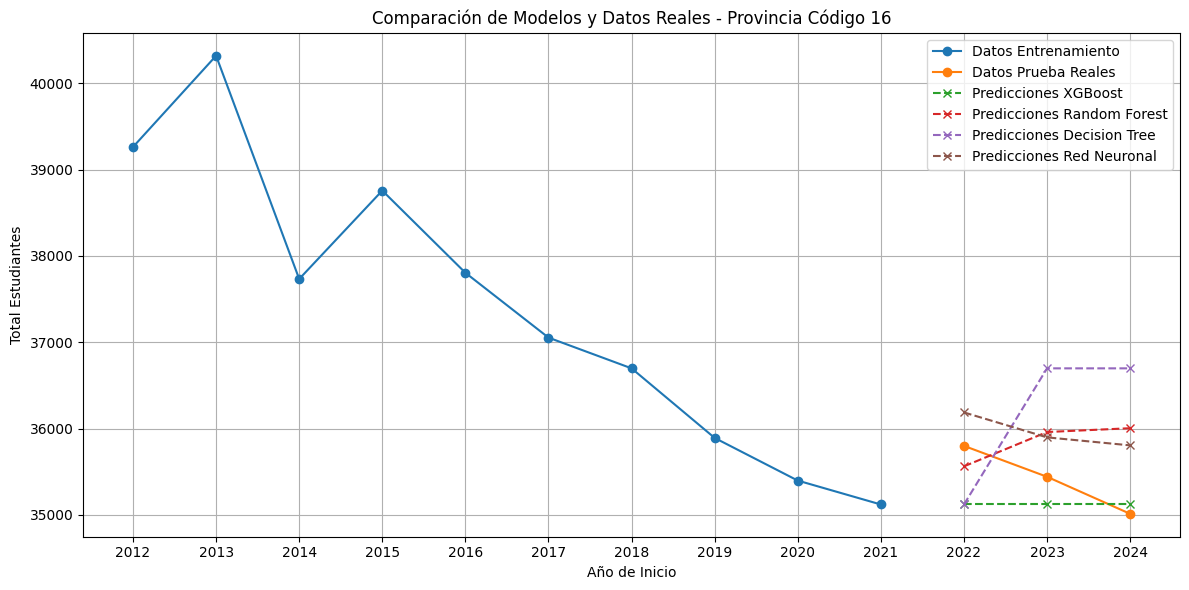

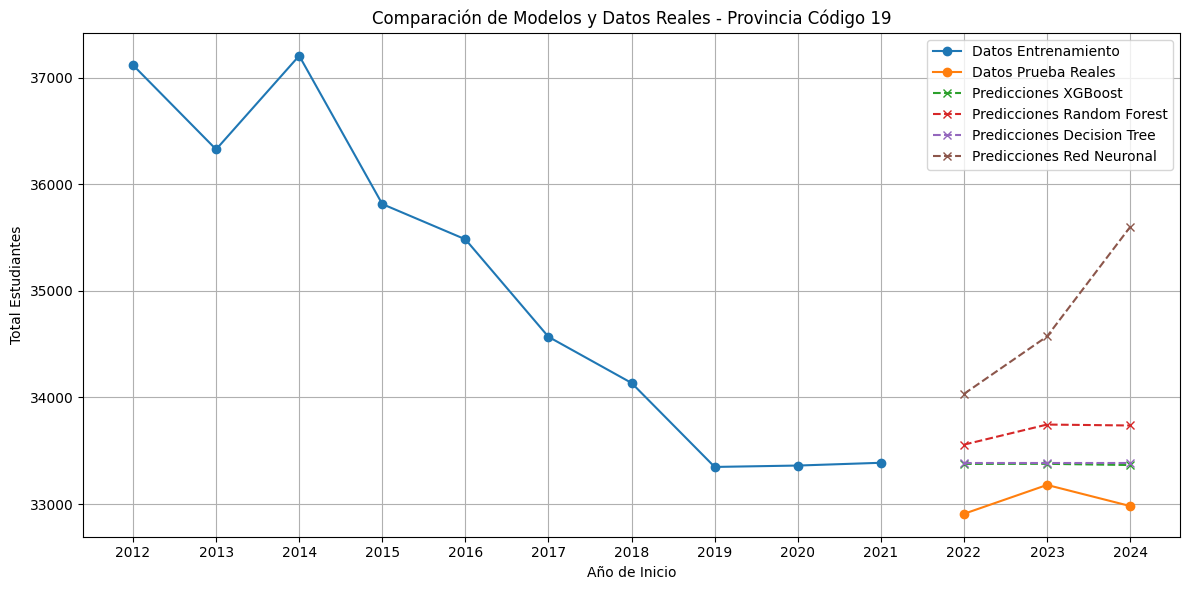

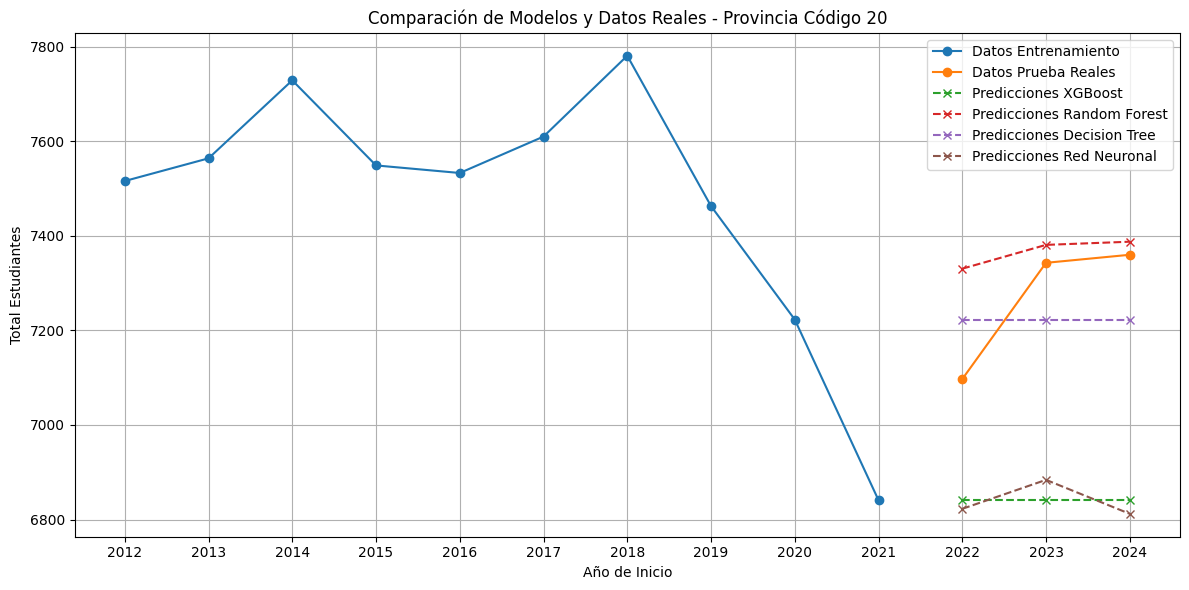

In [27]:
# Seleccionar las provincias de interés
provincias_interes = [14, 15, 16, 19, 20]

# Iterar sobre cada provincia seleccionada
for cod_provincia in provincias_interes:
    # Verificar si la provincia existe en los datos divididos
    if cod_provincia in province_data_splits:
        # Obtener los datos divididos para la provincia actual
        splits = province_data_splits[cod_provincia]
        X_train_prov = splits['X_train']
        y_train_prov = splits['y_train']
        X_test_prov = splits['X_test']
        y_test_prov = splits['y_test']

        # Obtener las predicciones de los modelos para esta provincia
        # Asegúrate de que los diccionarios de predicciones contengan la provincia
        y_pred_xgb_prov = xgbr_predictions_por_provincia.get(cod_provincia)
        y_pred_rf_prov = rf_predictions_por_provincia.get(cod_provincia)
        y_pred_dt_prov = dt_predictions_por_provincia.get(cod_provincia)
        y_pred_nn_prov = nn_predictions_por_provincia.get(cod_provincia)

        # Crear la gráfica para la provincia actual
        plt.figure(figsize=(12, 6))

        # Graficar datos de entrenamiento
        plt.plot(X_train_prov['Anio_Inicio'], y_train_prov, label='Datos Entrenamiento', marker='o', linestyle='-')

        # Graficar datos de prueba reales
        plt.plot(X_test_prov['Anio_Inicio'], y_test_prov, label='Datos Prueba Reales', marker='o', linestyle='-')

        # Graficar predicciones de cada modelo si existen
        if y_pred_xgb_prov is not None:
             plt.plot(X_test_prov['Anio_Inicio'], y_pred_xgb_prov, label='Predicciones XGBoost', marker='x', linestyle='--')
        if y_pred_rf_prov is not None:
             plt.plot(X_test_prov['Anio_Inicio'], y_pred_rf_prov, label='Predicciones Random Forest', marker='x', linestyle='--')
        if y_pred_dt_prov is not None:
             plt.plot(X_test_prov['Anio_Inicio'], y_pred_dt_prov, label='Predicciones Decision Tree', marker='x', linestyle='--')
        if y_pred_nn_prov is not None:
             plt.plot(X_test_prov['Anio_Inicio'], y_pred_nn_prov, label='Predicciones Red Neuronal', marker='x', linestyle='--')


        # Configurar título y etiquetas
        plt.title(f'Comparación de Modelos y Datos Reales - Provincia Código {cod_provincia}')
        plt.xlabel('Año de Inicio')
        plt.ylabel('Total Estudiantes')
        plt.xticks(sorted(X_train_prov['Anio_Inicio'].tolist() + X_test_prov['Anio_Inicio'].tolist())) # Asegura que se muestren todos los años
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No hay datos disponibles para la Provincia Código {cod_provincia}. Saltando...")

In [28]:
# Predicción de 4 años futuros para cada provincia usando el modelo XGBoost
future_years_to_predict = 4
start_year_future = df_final['Anio_Inicio'].max() + 1 # El año siguiente al último año en los datos
future_years = list(range(start_year_future, start_year_future + future_years_to_predict))

# DataFrame para almacenar todas las predicciones futuras
all_future_predictions = pd.DataFrame()

# Iterar sobre cada provincia para la que tenemos un modelo entrenado
for cod_provincia in xgbr_models_por_provincia.keys(): # Usamos las keys del diccionario de modelos entrenados

    # Obtener el último año de datos históricos para la provincia
    last_year_data = df_final[df_final['Cod_Provincia'] == cod_provincia].sort_values(by='Anio_Inicio').tail(1)

    # Verificar si hay datos históricos disponibles para esta provincia
    if last_year_data.empty:
        print(f"No se encontraron datos históricos para la Provincia Código {cod_provincia}. Saltando...")
        continue

    # Obtener el modelo XGBoost entrenado para esta provincia
    xgbr_model_prov = xgbr_models_por_provincia[cod_provincia]

    # Lista para almacenar las predicciones de esta provincia
    province_future_predictions = []

    # Inicializar el estado para la predicción recursiva
    # Usamos los valores del último año histórico para empezar
    current_features = last_year_data.drop(columns=['Anio_Inicio', 'Total_Estudiantes']).iloc[0].to_dict()

    # Predecir los 4 años futuros
    for year in future_years:
        # Crear el DataFrame de características para el año actual de predicción
        # Mantener las columnas que no son lags con el último valor conocido
        # Actualizar las columnas de lag
        features_df = pd.DataFrame([current_features])

        # Añadir 'Cod_Provincia' y 'Anio_Inicio' para mantener la estructura
        features_df['Cod_Provincia'] = cod_provincia
        features_df['Anio_Inicio'] = year

        # Reordenar las columnas para que coincidan con el orden de entrenamiento (excepto la variable objetivo)
        # Asegurarse de que el orden sea el mismo que X_train_prov en la división
        # Tomamos las columnas del primer X_train disponible (asumimos que tienen el mismo orden)
        sample_X_train_cols = list(list(province_data_splits.values())[0]['X_train'].columns)
        features_df = features_df[sample_X_train_cols]


        # Realizar la predicción para el año actual
        predicted_students = xgbr_model_prov.predict(features_df)[0]

        # Asegurarse de que la predicción sea no negativa
        predicted_students = max(0, predicted_students)

        # Almacenar la predicción para este año y provincia
        province_future_predictions.append({
            'Cod_Provincia': cod_provincia,
            'Anio_Inicio': year,
            'Total_Estudiantes_Predicho': predicted_students
        })

        # Actualizar los valores de lag para la predicción del siguiente año
        # Shift the lags: lag3 becomes lag4 (ignored), lag2 becomes lag3, lag1 becomes lag2
        current_features['Total_Estudiantes_lag3'] = current_features['Total_Estudiantes_lag2']
        current_features['Total_Estudiantes_lag2'] = current_features['Total_Estudiantes_lag1']
        # The new lag1 is the prediction from the current year
        current_features['Total_Estudiantes_lag1'] = predicted_students

    # Convertir las predicciones de la provincia a DataFrame y agregarlas al DataFrame global
    df_province_future = pd.DataFrame(province_future_predictions)
    all_future_predictions = pd.concat([all_future_predictions, df_province_future], ignore_index=True)

# Opcional: Redondear las predicciones a enteros ya que son números de estudiantes
all_future_predictions['Total_Estudiantes_Predicho'] = all_future_predictions['Total_Estudiantes_Predicho'].round().astype(int)

# Descargar el DataFrame con todas las predicciones futuras
output_filename = 'predicciones.csv'
all_future_predictions.to_csv(output_filename, index=False)

print(f"\nDataFrame con predicciones futuras guardado como '{output_filename}'")

# Descargar el archivo desde Colab
files.download(output_filename)



DataFrame con predicciones futuras guardado como 'predicciones.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Widget de entrada de texto para el código de provincia
provincia_input = widgets.Text(
    value='',
    placeholder='Ingrese Código de Provincia',
    description='Provincia:',
    disabled=False
)

# Widget de entrada de texto para el año
year_input = widgets.Text(
    value='',
    placeholder='Ingrese Año (2025-2028)',
    description='Año:',
    disabled=False
)

# Botón para ver la predicción
ver_prediccion_button = widgets.Button(
    description='Ver Predicción'
)

# Output para mostrar el resultado
output = widgets.Output()

# Función para manejar el evento click del botón
def on_button_clicked(b):
    with output:
        output.clear_output()  # Limpiar salida anterior
        try:
            # Obtener los valores ingresados por el usuario
            cod_provincia_str = provincia_input.value
            year_str = year_input.value

            # Validar que los campos no estén vacíos
            if not cod_provincia_str or not year_str:
                print("Por favor, ingrese tanto el código de provincia como el año.")
                return

            cod_provincia = int(cod_provincia_str)
            year = int(year_str)

            # Filtrar las predicciones para la provincia y año especificados
            prediccion_filtrada = all_future_predictions[
                (all_future_predictions['Cod_Provincia'] == cod_provincia) &
                (all_future_predictions['Anio_Inicio'] == year)
            ]

            # Mostrar el resultado
            if not prediccion_filtrada.empty:
                predicted_students = prediccion_filtrada['Total_Estudiantes_Predicho'].iloc[0]
                print(f"📊 Predicción para Provincia {cod_provincia} en {year}: {predicted_students:,} estudiantes")
            else:
                print(f"⚠️ No se encontró predicción para Provincia {cod_provincia} en el año {year}. Asegúrese de ingresar un año entre 2025 y 2028.")

        except ValueError:
            print("❗ Por favor, ingrese valores numéricos válidos para el código de provincia y el año.")
        except Exception as e:
            print(f"🚫 Ocurrió un error: {e}")

# Asociar la función al evento click del botón
ver_prediccion_button.on_click(on_button_clicked)

# Mostrar los widgets
display(provincia_input, year_input, ver_prediccion_button, output)

# Agregar un título explicativo
print("🔍 Ingrese el código de provincia y el año para ver la predicción de estudiantes.")

Text(value='', description='Provincia:', placeholder='Ingrese Código de Provincia')

Text(value='', description='Año:', placeholder='Ingrese Año (2025-2028)')

Button(description='Ver Predicción', style=ButtonStyle())

Output()

🔍 Ingrese el código de provincia y el año para ver la predicción de estudiantes.


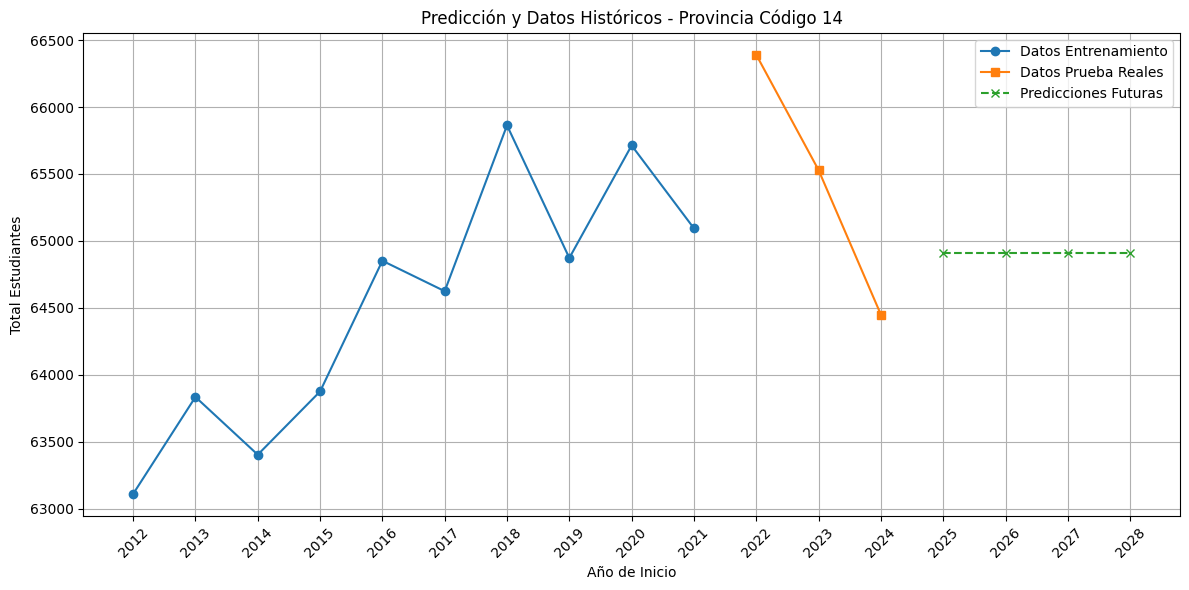

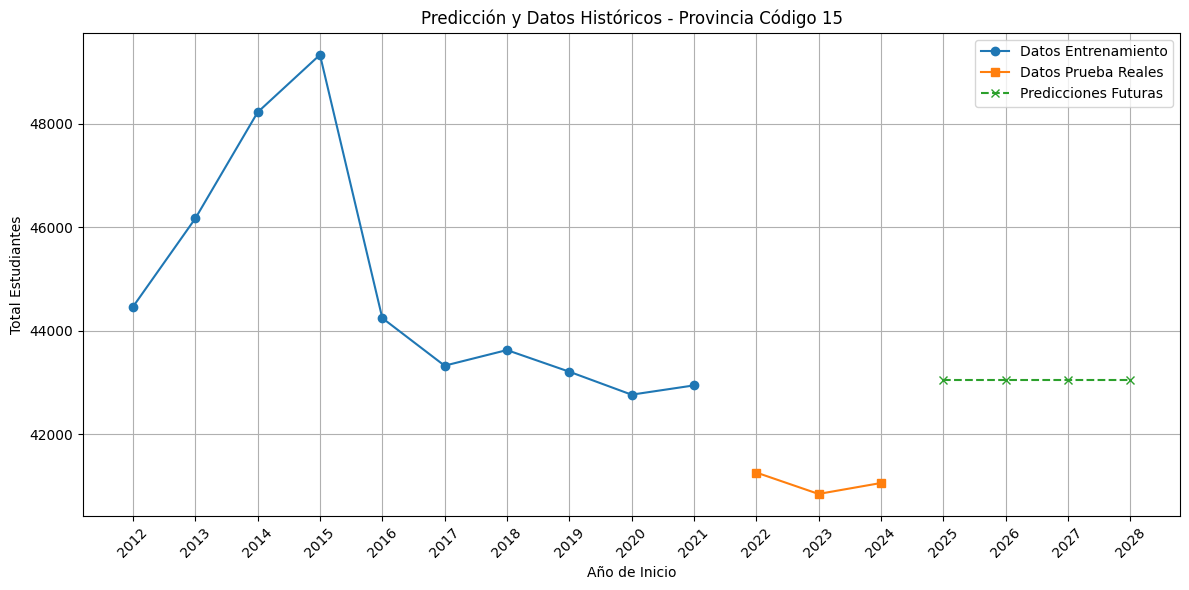

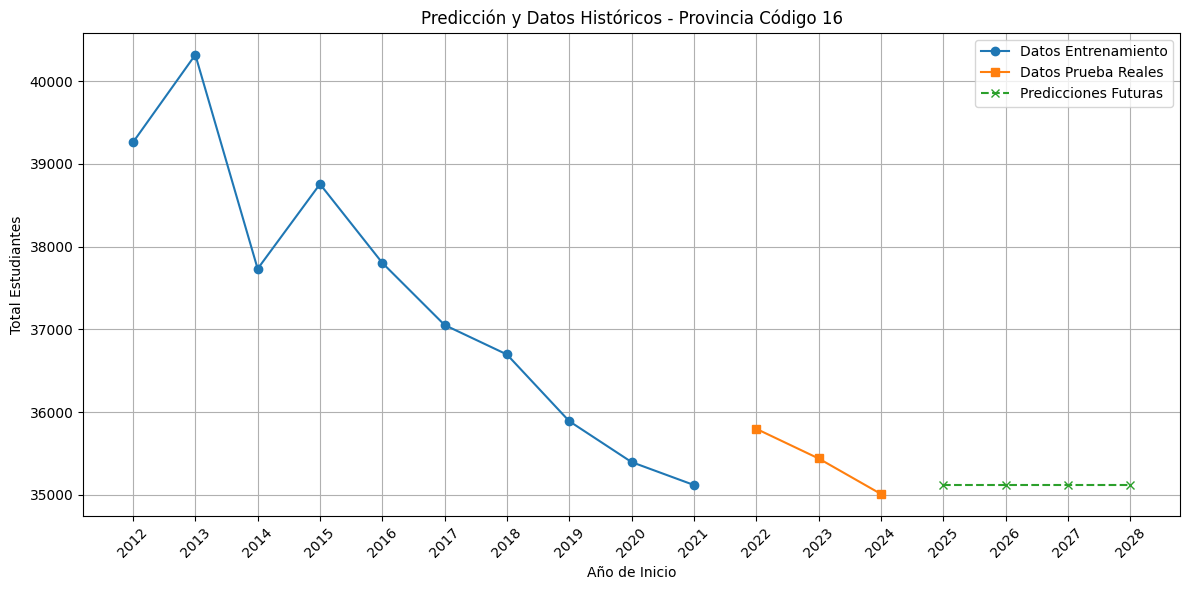

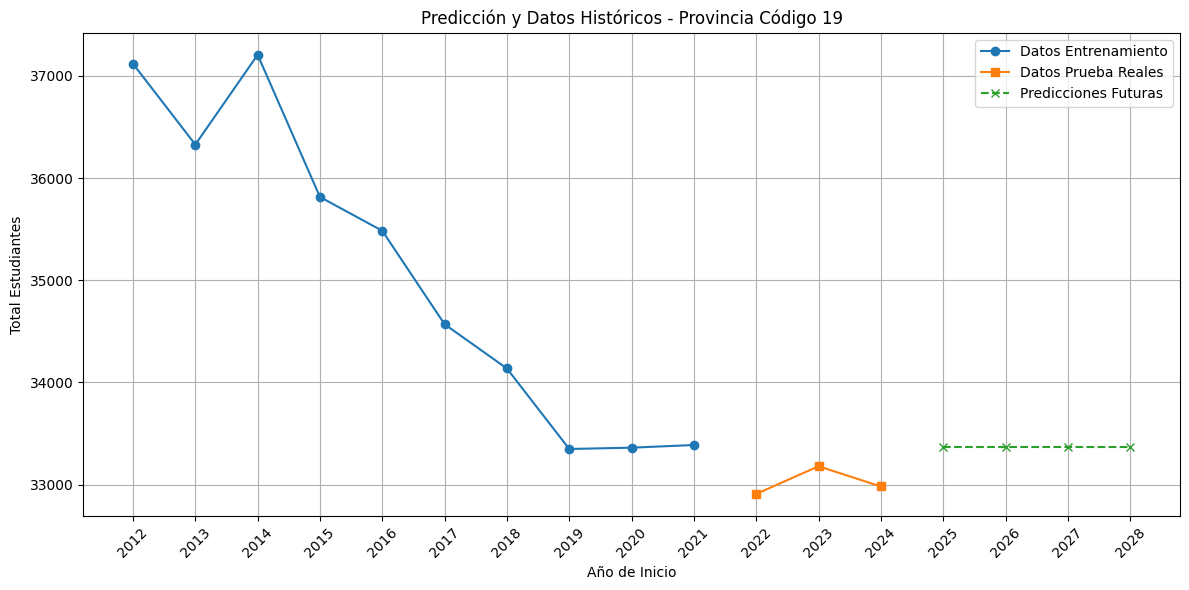

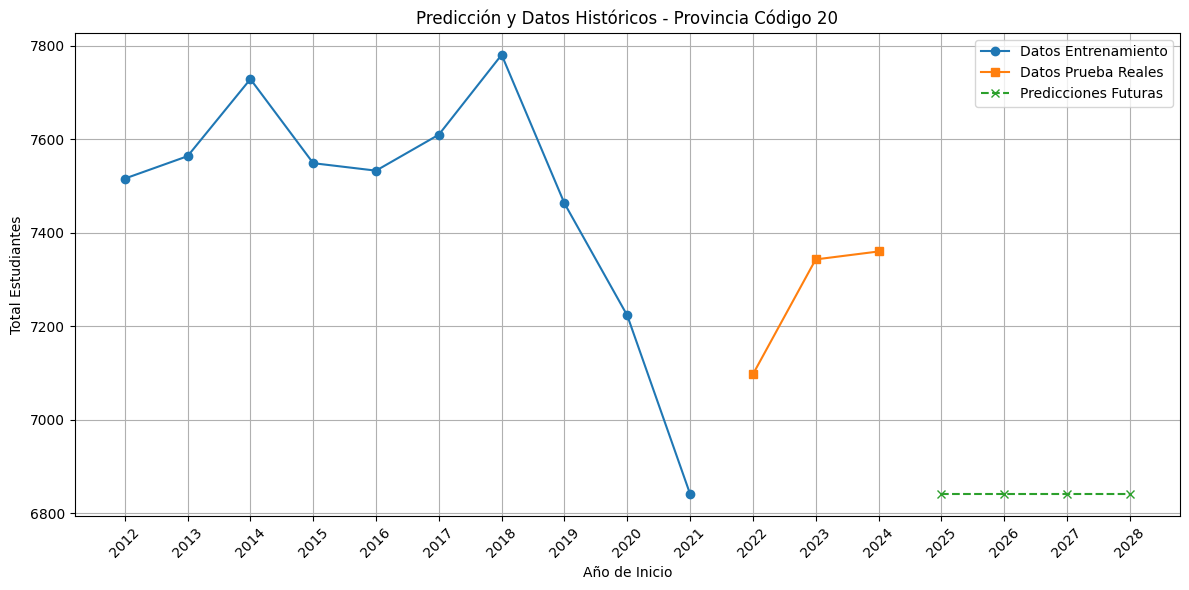

In [30]:
# Iterar sobre cada provincia seleccionada para graficar predicciones
for cod_provincia in provincias_interes:
    # Verificar si la provincia existe en los datos de predicciones
    if cod_provincia in all_future_predictions['Cod_Provincia'].unique():

        # Filtrar las predicciones para la provincia actual
        predicciones_prov = all_future_predictions[
            all_future_predictions['Cod_Provincia'] == cod_provincia
        ].copy()

        # Obtener los datos reales de entrenamiento y prueba para esta provincia
        if cod_provincia in province_data_splits:
            splits = province_data_splits[cod_provincia]
            X_train_prov = splits['X_train']
            y_train_prov = splits['y_train']
            X_test_prov = splits['X_test']
            y_test_prov = splits['y_test']

            # Crear la gráfica
            plt.figure(figsize=(12, 6))

            # Graficar datos de entrenamiento (hasta 2021)
            plt.plot(X_train_prov['Anio_Inicio'], y_train_prov,
                     label='Datos Entrenamiento', marker='o', linestyle='-')

            # Graficar datos reales de prueba (2022-2024)
            if not X_test_prov.empty:
                plt.plot(X_test_prov['Anio_Inicio'], y_test_prov,
                         label='Datos Prueba Reales', marker='s', linestyle='-')

            # Graficar las predicciones futuras (2025 en adelante)
            plt.plot(predicciones_prov['Anio_Inicio'], predicciones_prov['Total_Estudiantes_Predicho'],
                     label='Predicciones Futuras', marker='x', linestyle='--')

            # Configurar gráfico
            plt.title(f'Predicción y Datos Históricos - Provincia Código {cod_provincia}')
            plt.xlabel('Año de Inicio')
            plt.ylabel('Total Estudiantes')
            all_years = sorted(
                X_train_prov['Anio_Inicio'].tolist() +
                X_test_prov['Anio_Inicio'].tolist() +
                predicciones_prov['Anio_Inicio'].tolist()
            )
            plt.xticks(all_years, rotation=45)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            print(f"⚠️ No se encontraron datos históricos para la Provincia Código {cod_provincia}.")
    else:
        print(f"❌ No hay predicciones disponibles para la Provincia Código {cod_provincia}.")
